<a href="https://colab.research.google.com/github/fatihdzaki01/GelarRasa_ML/blob/fatih-dev/NLP_GelarRasa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [1]:
!pip install pandas transformers torch tqdm

In [2]:
import pandas as pd

# kalau file kamu di-upload ke Colab manual:
from google.colab import files
uploaded = files.upload()

# setelah upload, misal nama file kamu 'reviews.csv'
df = pd.read_csv("reviews.csv")
df.head()


Saving reviews.csv to reviews.csv


,review_id,product_id,date,rating,sentiment,platform,comment
0,R100000,PC014,10/16/2024,4.6,Positive,Instagram,"Packaging bocor saat diterima, kurang aman."
1,R100001,PC012,6/27/2023,2.8,Negative,Instagram,"Mudah dibeli saat promo, value for money."
2,R100002,PC003,10/21/2022,3.2,Neutral,Shopee,"Mudah dibeli saat promo, value for money."
3,R100003,PC010,3/7/2025,2.0,Negative,Tokopedia,"Mudah dibeli saat promo, value for money."
4,R100004,PC015,3/3/2022,1.5,Negative,Shopee,Memberikan hasil sesuai klaim after 2 weeks.


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "taufiqdp/indonesian-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/922 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Device set to use cpu


In [4]:
from tqdm import tqdm

tqdm.pandas()

# apply NLP model ke setiap baris comment
df["predicted_sentiment"] = df["comment"].progress_apply(lambda x: sentiment_pipeline(x)[0]["label"])
df.head()


100%|██████████| 10000/10000 [14:45<00:00, 11.29it/s]


,review_id,product_id,date,rating,sentiment,platform,comment,predicted_sentiment
0,R100000,PC014,10/16/2024,4.6,Positive,Instagram,"Packaging bocor saat diterima, kurang aman.",negatif
1,R100001,PC012,6/27/2023,2.8,Negative,Instagram,"Mudah dibeli saat promo, value for money.",netral
2,R100002,PC003,10/21/2022,3.2,Neutral,Shopee,"Mudah dibeli saat promo, value for money.",netral
3,R100003,PC010,3/7/2025,2.0,Negative,Tokopedia,"Mudah dibeli saat promo, value for money.",netral
4,R100004,PC015,3/3/2022,1.5,Negative,Shopee,Memberikan hasil sesuai klaim after 2 weeks.,netral


In [30]:
df = df.drop(columns=["rating_label"])

In [31]:
df = df.drop(columns=["consistency"])

In [32]:
# Konversi rating (angka 1–5) menjadi label sentimen
def label_from_rating(r):
    if r >= 4.0:
        return "positif"
    elif r >= 3:
        return "netral"
    else:
        return "negatif"

# Terapkan fungsi ke kolom rating
df["rating_label"] = df["rating"].apply(label_from_rating)

# Cek hasil konversi awal
df[["rating", "rating_label"]].head(10)


,rating,rating_label
0,4.6,positif
1,2.8,negatif
2,3.2,netral
3,2.0,negatif
4,1.5,negatif
5,4.9,positif
6,3.1,netral
7,1.5,negatif
8,4.2,positif
9,2.0,negatif


In [33]:
# Bandingkan hanya antara hasil prediksi model NLP dan label dari rating
def check_consistency(row):
    if row["predicted_sentiment"] == row["rating_label"]:
        return "konsisten"
    else:
        return "Inkonsisten"

# Tambahkan kolom hasil ke dataframe utama
df["consistency"] = df.apply(check_consistency, axis=1)

# Cek jumlah hasil awal
df["consistency"].value_counts()

,count
consistency,
Inkonsisten,6529
konsisten,3471


In [34]:
df_konsisten = df[df["consistency"] == "konsisten"]
df_inkonsisten = df[df["consistency"] == "Inkonsisten"]

Lakukan Analisa untuk row yang konsisten

In [35]:
df_konsisten.head()

,review_id,product_id,date,rating,sentiment,platform,comment,predicted_sentiment,rating_label,consistency
2,R100002,PC003,10/21/2022,3.2,Neutral,Shopee,"Mudah dibeli saat promo, value for money.",netral,netral,konsisten
5,R100005,PC005,8/20/2021,4.9,Positive,Instagram,Kemasan baru lebih ramah lingkungan.,positif,positif,konsisten
8,R100008,PC010,12/11/2021,4.2,Positive,Instagram,"Harga sesuai, kualitas oke.",positif,positif,konsisten
9,R100009,PC012,6/24/2024,2.0,Negative,Tokopedia,Wangi terlalu kuat untuk saya.,negatif,negatif,konsisten
15,R100015,PC006,2/1/2020,1.5,Negative,Shopee,"Packaging bocor saat diterima, kurang aman.",negatif,negatif,konsisten


In [42]:
len(df_konsisten)

3471

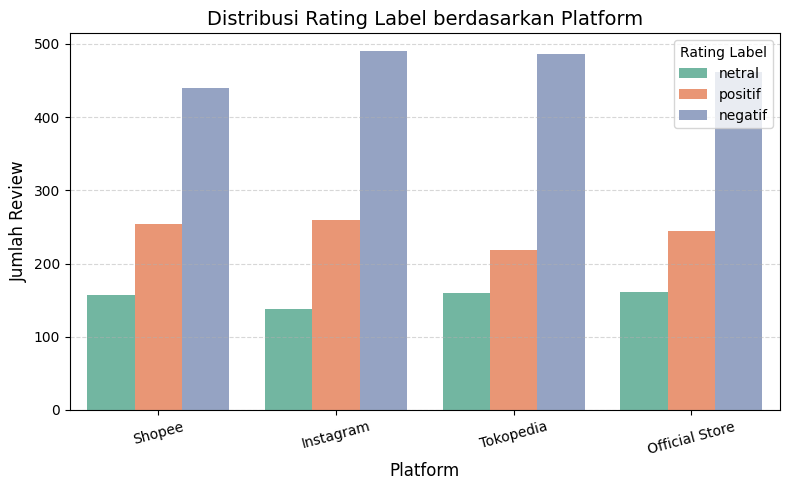

In [45]:
#Visualisasi rating_label berdasarkan platform

plt.figure(figsize=(8,5))
sns.countplot(
    data=df_konsisten,
    x="platform",
    hue="rating_label",
    palette="Set2"
)
plt.title("Distribusi Rating Label berdasarkan Platform", fontsize=14)
plt.xlabel("Platform", fontsize=12)
plt.ylabel("Jumlah Review", fontsize=12)
plt.legend(title="Rating Label", loc="upper right")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [50]:
df_konsisten["date"] = pd.to_datetime(df_konsisten["date"], errors="coerce")

/tmp/ipython-input-1068256603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_konsisten["date"] = pd.to_datetime(df_konsisten["date"], errors="coerce")


In [51]:
tahun_min = df_konsisten["date"].dt.year.min()
tahun_max = df_konsisten["date"].dt.year.max()

print("Rentang tahun data:", tahun_min, "-", tahun_max)


Rentang tahun data: 2020 - 2026


In [53]:
df_konsisten["year"] = df_konsisten["date"].dt.year

/tmp/ipython-input-3645102854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_konsisten["year"] = df_konsisten["date"].dt.year


/tmp/ipython-input-576367728.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_konsisten, x="year", palette="pastel")


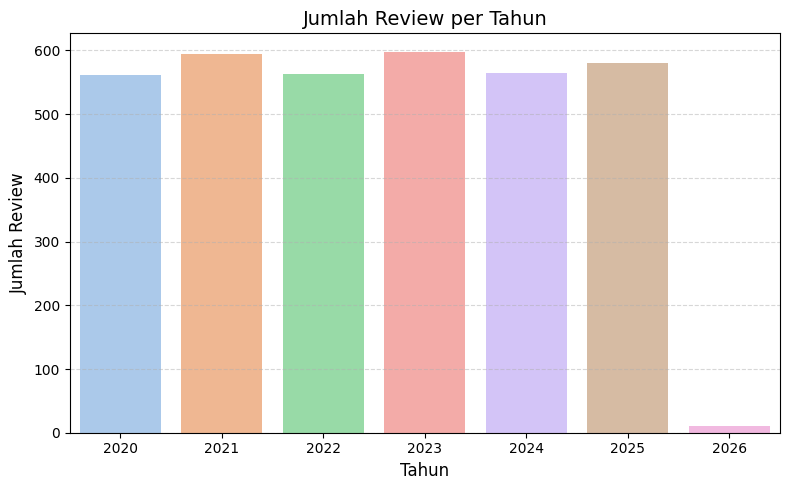

In [54]:
plt.figure(figsize=(8,5))
sns.countplot(data=df_konsisten, x="year", palette="pastel")
plt.title("Jumlah Review per Tahun", fontsize=14)
plt.xlabel("Tahun", fontsize=12)
plt.ylabel("Jumlah Review", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()